In [1]:
from glob import glob
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
from mido import MidiFile
from tqdm import tqdm
from shutil import copyfile
import pickle
import mido
import random
 
# labels = glob("./data/rousseau/labels/testing/*")
# labels = sorted(labels, key=lambda x: int(x.split("/")[-1].split("_")[0]))

In [2]:
images = glob("./data/customdata/images/*")
images = sorted(images, key=lambda x: int(x.split("/")[-1].split("_")[0]))

In [3]:
def intkey_to_str(arr):
    notes = ["A", "A#", "B", "C", "C#", "D", "D#", "E", "F", "F#", "G", "G#"]
    notes_str = []
    for key_int in arr:
        note = notes[key_int%12]
        octave = (key_int+9) // 12 + 1
        notes_str.append(note + str(octave))
    return notes_str

In [4]:
def show_5_images(image_idx_mid):
    assert image_idx_mid >= 1
    plt.figure(figsize=(20, 15))
    plt.axis("off")
    plt.subplot(5, 1, 1)
    plt.title(img_list[image_idx_mid-3])
    plt.imshow(Image.open(os.path.join(images[idx], img_list[image_idx_mid-3])))
    plt.subplot(5, 1, 2)
    plt.title(img_list[image_idx_mid-2])
    plt.imshow(Image.open(os.path.join(images[idx], img_list[image_idx_mid-2])))
    plt.subplot(5, 1, 3)
    plt.title(img_list[image_idx_mid-1])
    plt.imshow(Image.open(os.path.join(images[idx], img_list[image_idx_mid-1]))) # mid
    plt.subplot(5, 1, 4)
    plt.title(img_list[image_idx_mid])
    plt.imshow(Image.open(os.path.join(images[idx], img_list[image_idx_mid])))
    plt.subplot(5, 1, 5)
    plt.title(img_list[image_idx_mid+1])
    plt.imshow(Image.open(os.path.join(images[idx], img_list[image_idx_mid+1])))

In [432]:
# start from here

idx = 8
print(images[idx])
# print(labels[idx])

data_id = images[idx].split("/")[-1].split("_")[0]
img_list = sorted(os.listdir(images[idx]), key=lambda x: int(x.split(".")[0]))

./data/customdata/images/1108_reminiscence.mp4


In [433]:
# label_np = np.stack(list(label.values()))
img_list = sorted(os.listdir(images[idx]), key=lambda x: int(x.split(".")[0]))

In [441]:
# FIND YOURSELF WITH show_5_images
# first try 126
image_onset_start = 100

/tmp/ipykernel_17258/2945813028.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(5, 1, 1)


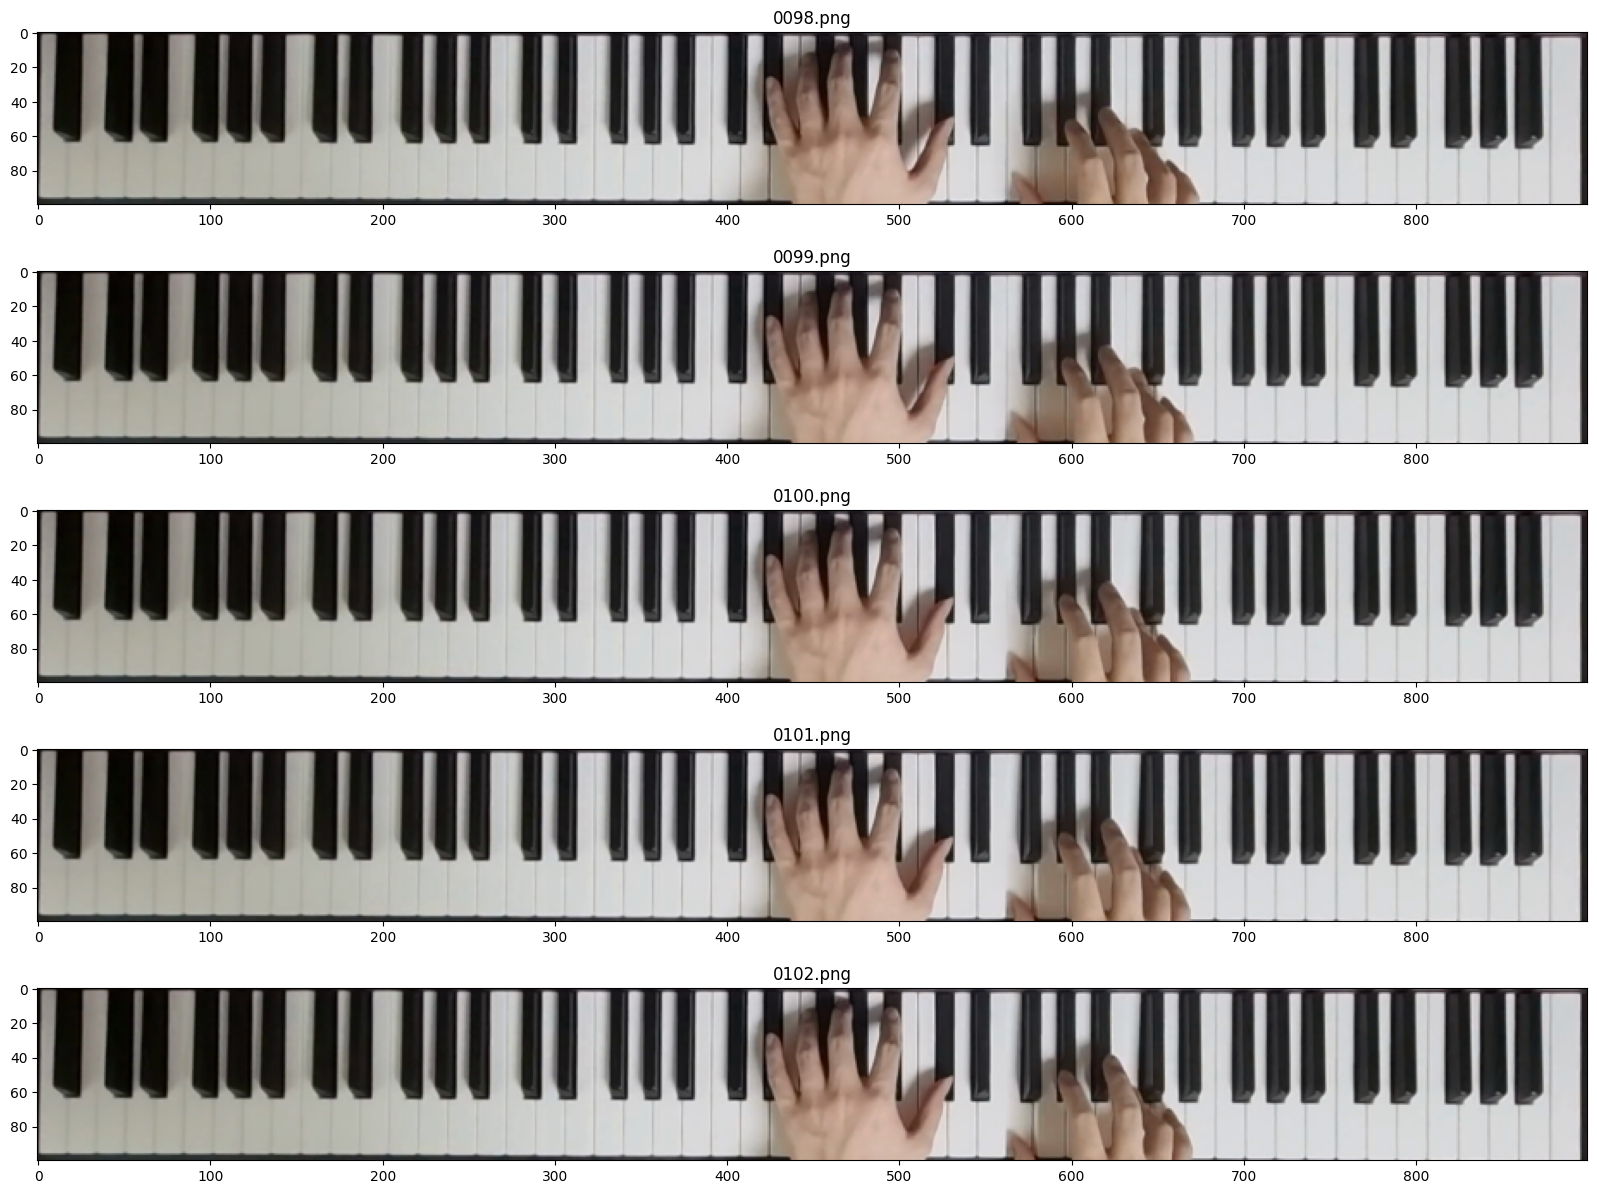

In [442]:
show_5_images(image_onset_start)

In [443]:
# tempo가 곡마다 다름. ticks per beat 480, 초당 192 tick
# time을 192로 나누면 초로 바뀜
# pedal time도 포함
# fps 25, 
print(glob(f"./data/customdata/midi_gt/{data_id}_*.mid"))
test_midi = MidiFile(glob(f"./data/customdata/midi_gt/{data_id}_*.mid")[0])

['./data/customdata/midi_gt/1108_reminiscence.mid']


In [444]:
cur_tempo = None
for msg in test_midi.tracks[1]:
    if msg.type == 'set_tempo':
        cur_tempo = msg.tempo
bpm = mido.tempo2bpm(cur_tempo)
bps = bpm / 60
tpb = test_midi.ticks_per_beat
tps = bps*tpb
print(tps)

192.0


In [445]:
for msg in test_midi.tracks[2]:
    msg.time = 0
    if msg.type == "note_on":
        break

time_sum = 0
for msg in test_midi.tracks[2]:
    time_sum += msg.time
    msg.time = time_sum

In [446]:
msg_list = []
for midi_track in test_midi.tracks:
    for msg in midi_track:
        if msg.type == 'note_on' or msg.type == 'note_off':
            msg_type = msg.type
            msg_pitch = msg.note-21 # A1
            time_second = (msg.time / tps)
            frame_num = time_second * 25
            msg_list.append({"type": msg_type, "pitch": msg_pitch, "sec" : time_second, "frame": frame_num})

In [447]:
msg_list = sorted(msg_list, key=lambda x: x['sec'])

In [448]:
note_list = []
for msg in msg_list:
    if msg['type'] == 'note_on':
        note_list.append({"pitch": msg['pitch'], "onset": round(msg['frame']), "offset": None})
    elif msg['type'] == 'note_off':
        for note in note_list:
            if note['pitch'] == msg['pitch'] and note['offset'] == None:
                note['offset'] = round(msg['frame'])
                break


In [449]:
last_frame = sorted(note_list, key=lambda x: x['offset'])[-1]['offset']

In [450]:
last_frame

3950

In [451]:
note_dict = {}

for i in range(last_frame+1):
    note_dict[i+3] = np.zeros(88)

for note in note_list:
    for i in range(note['onset'], note['offset']):
        note_dict[i+3][note['pitch']] = 1
    
note_dict[0] = np.zeros(88)
note_dict[1] = np.zeros(88)
note_dict[last_frame+4] = np.zeros(88)
note_dict[last_frame+5] = np.zeros(88)

In [452]:
image_last_frame = last_frame + image_onset_start

In [453]:
image_last_frame

4050

In [454]:
image_onset_start

100

In [455]:
img_name = images[idx].split("/")[-1]
for enum_i, i in enumerate(tqdm(range(image_onset_start-2, image_last_frame+3))):
    original_file_path = os.path.join(images[idx], f"{str(i).zfill(4)}.png")
    os.makedirs(os.path.join("./data/customdata/images_align/", img_name), exist_ok=True)
    target_file_path = os.path.join("./data/customdata/images_align/", img_name, f"{str(enum_i+1).zfill(4)}.png")
    copyfile(original_file_path, target_file_path)
    # os.system(f"cp '{original_file_path}' '{target_file_path}'")

100% 3955/3955 [00:00<00:00, 7727.92it/s]


In [456]:
note_dict = dict(sorted(note_dict.items()))
with open(os.path.join("./data/customdata/labels_align/", img_name + ".pkl"), "wb") as f:
    pickle.dump(note_dict, f)

----------

In [457]:
test_label = np.load(os.path.join("./data/customdata/labels_align/", img_name + ".pkl"), allow_pickle=True)
test_image_path = os.path.join("./data/customdata/images_align/", img_name)

In [458]:
test_image_path

'./data/customdata/images_align/1108_reminiscence.mp4'

In [459]:
test_label_np = np.stack(list(test_label.values()))

In [460]:
test_images_list = sorted(os.listdir(test_image_path), key=lambda x: int(x.split(".")[0]))

In [461]:
def show_5_images_test(image_idx_mid):
    assert image_idx_mid >= 1
    plt.figure(figsize=(20, 15))
    plt.axis("off")
    plt.subplot(5, 1, 1)
    plt.title(img_list[image_idx_mid-3])
    plt.imshow(Image.open(os.path.join(test_image_path, test_images_list[image_idx_mid-3])))
    plt.subplot(5, 1, 2)
    plt.title(img_list[image_idx_mid-2])
    plt.imshow(Image.open(os.path.join(test_image_path, test_images_list[image_idx_mid-2])))
    plt.subplot(5, 1, 3)
    plt.title(img_list[image_idx_mid-1])
    plt.imshow(Image.open(os.path.join(test_image_path, test_images_list[image_idx_mid-1]))) # mid
    plt.subplot(5, 1, 4)
    plt.title(img_list[image_idx_mid])
    plt.imshow(Image.open(os.path.join(test_image_path, test_images_list[image_idx_mid])))
    plt.subplot(5, 1, 5)
    plt.title(img_list[image_idx_mid+1])
    plt.imshow(Image.open(os.path.join(test_image_path, test_images_list[image_idx_mid+1])))

In [462]:
test_label_last_idx = test_label_np.shape[0]-3

In [463]:
assert intkey_to_str(np.where(test_label_np[1]>0)[0]) == []
assert intkey_to_str(np.where(test_label_np[test_label_last_idx+1]>0)[0]) == []
assert len(test_label) == len(os.listdir(test_image_path))

In [464]:
intkey_to_str(np.where(test_label_np[2]>0)[0])

['A#5', 'C#6', 'F6', 'C7']

/tmp/ipykernel_17258/476807092.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(5, 1, 1)


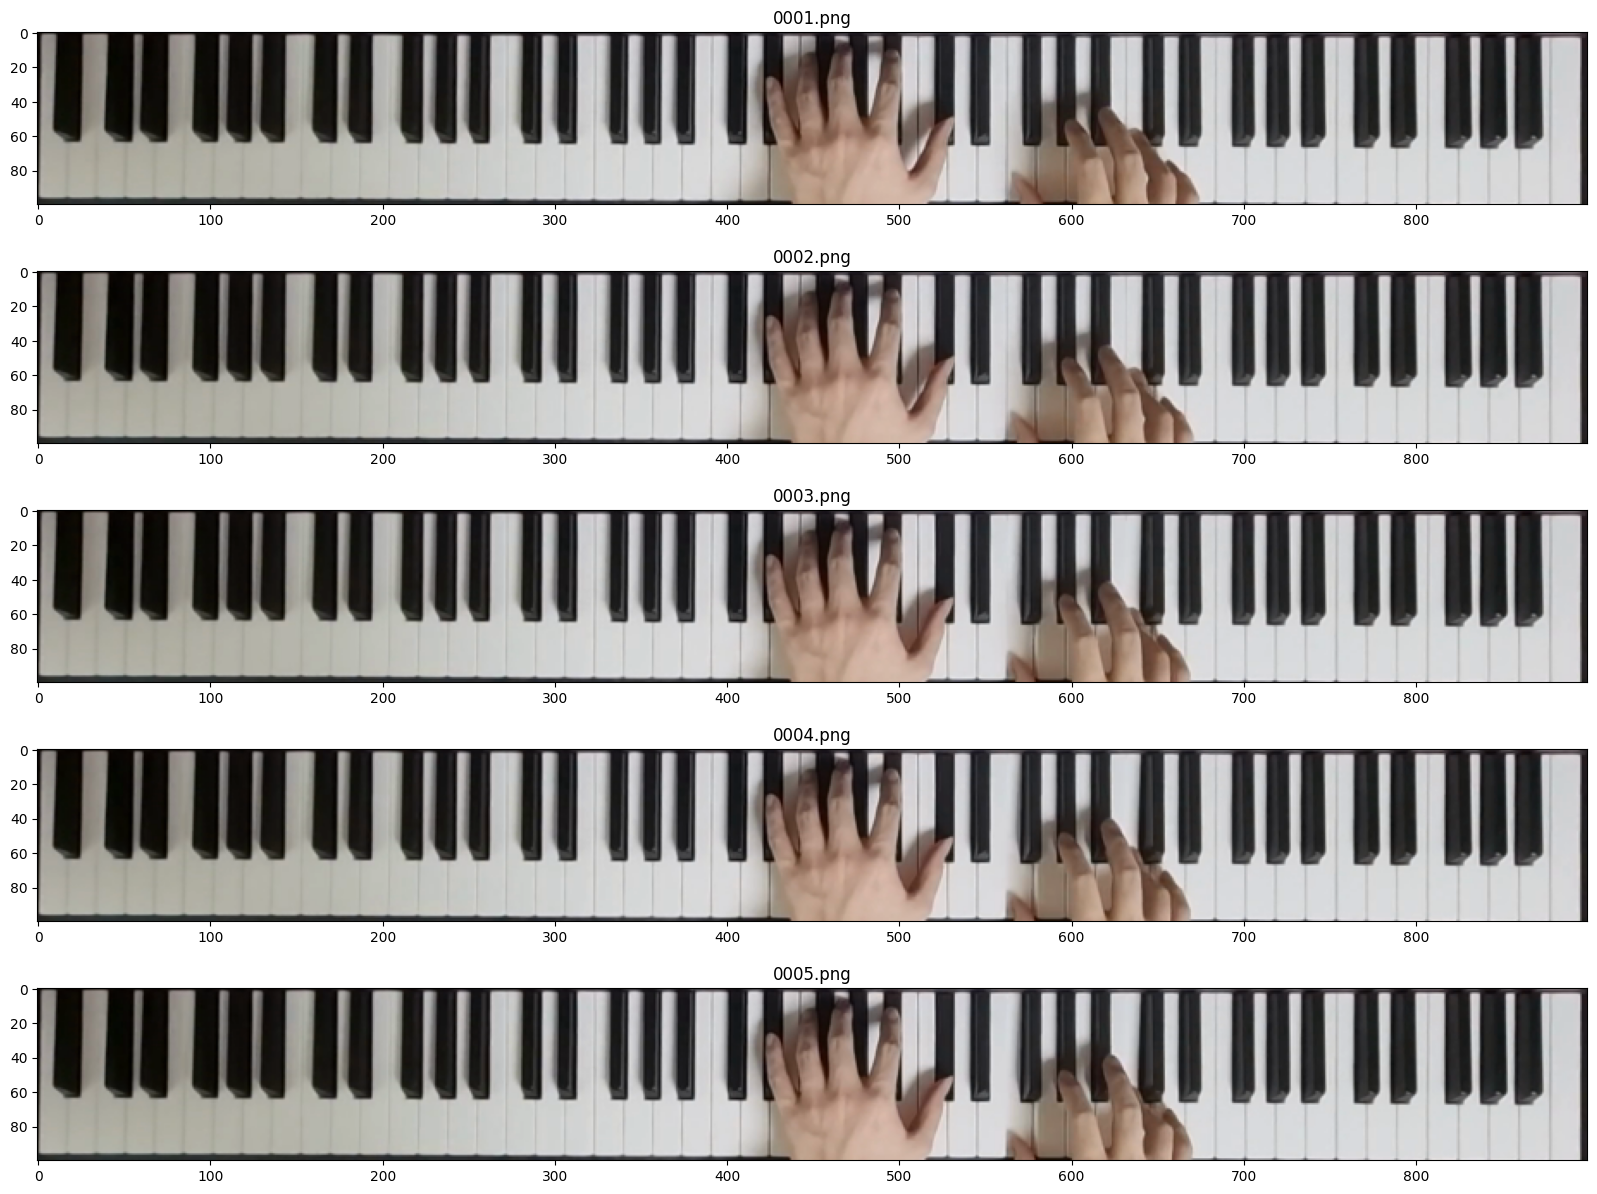

In [465]:
show_5_images_test(3)

In [466]:
intkey_to_str(np.where(test_label_np[test_label_last_idx-1]>0)[0])

['D#6', 'A#6']

/tmp/ipykernel_17258/476807092.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(5, 1, 1)


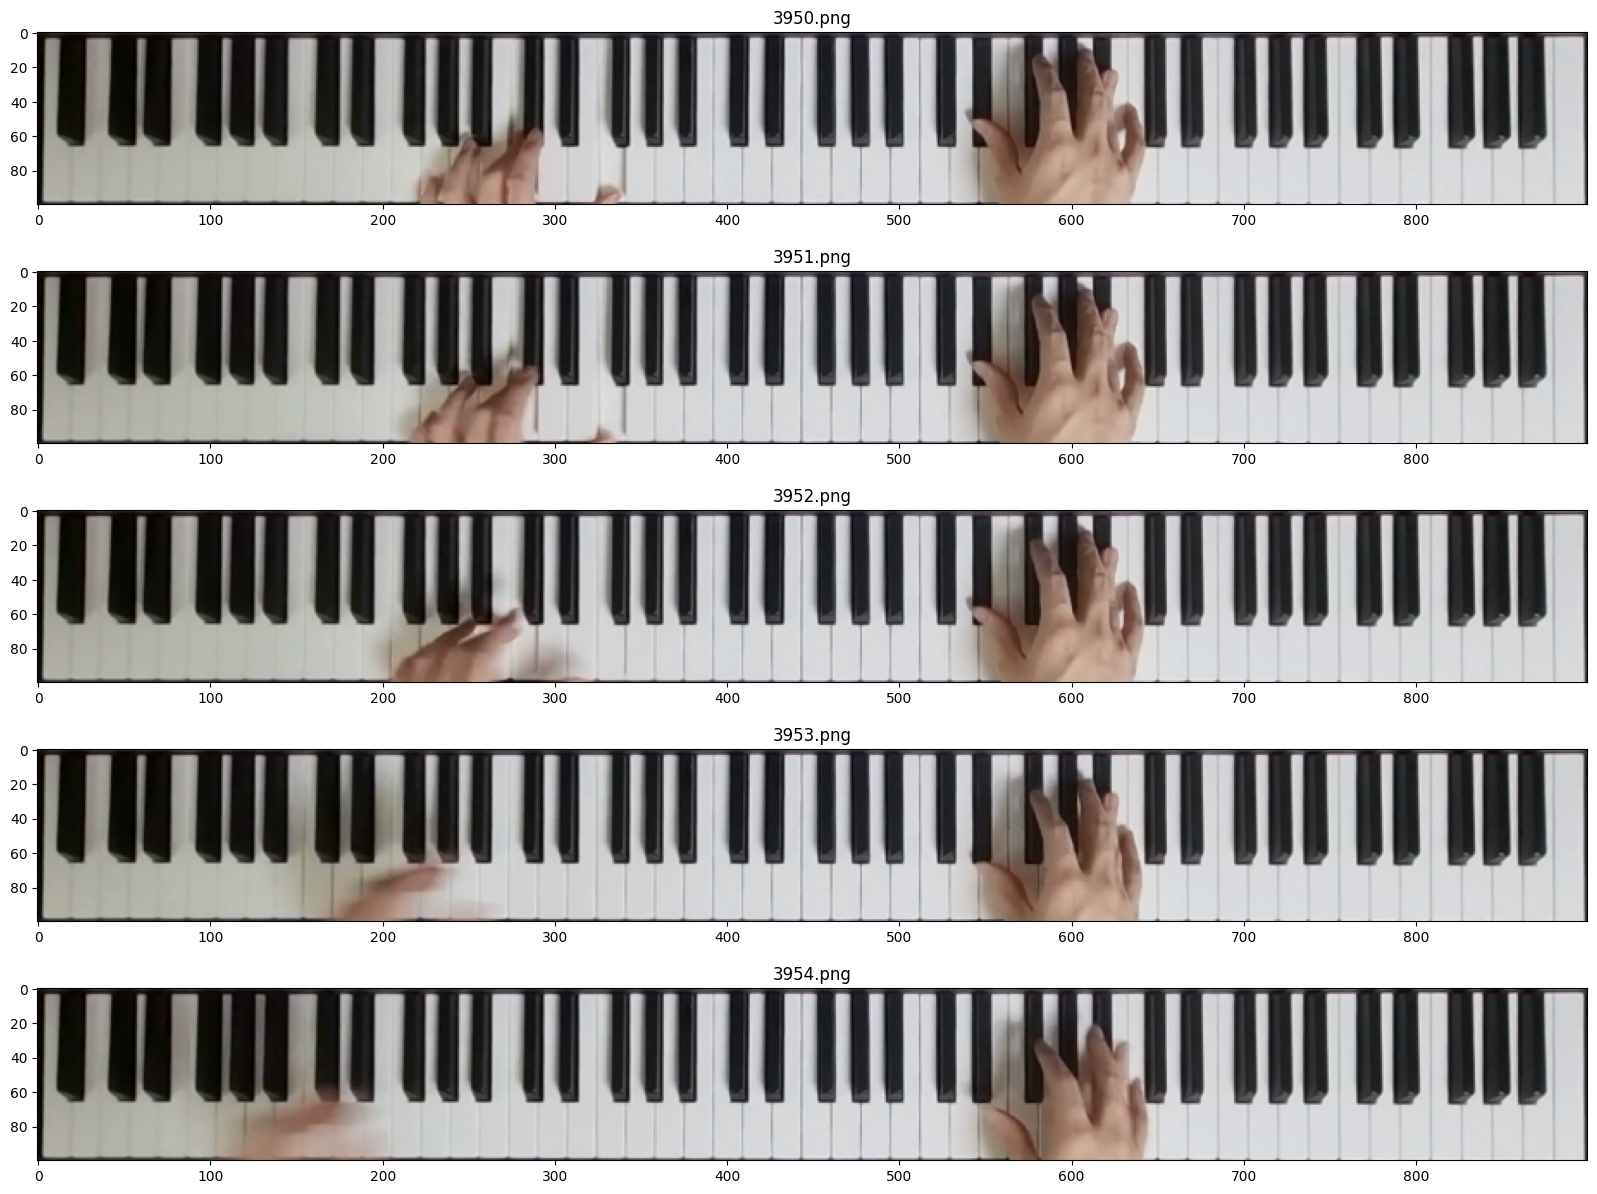

In [467]:
show_5_images_test(test_label_last_idx)

['F3', 'C4', 'D#4', 'A4', 'F#6', 'A6']


/tmp/ipykernel_17258/476807092.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(5, 1, 1)


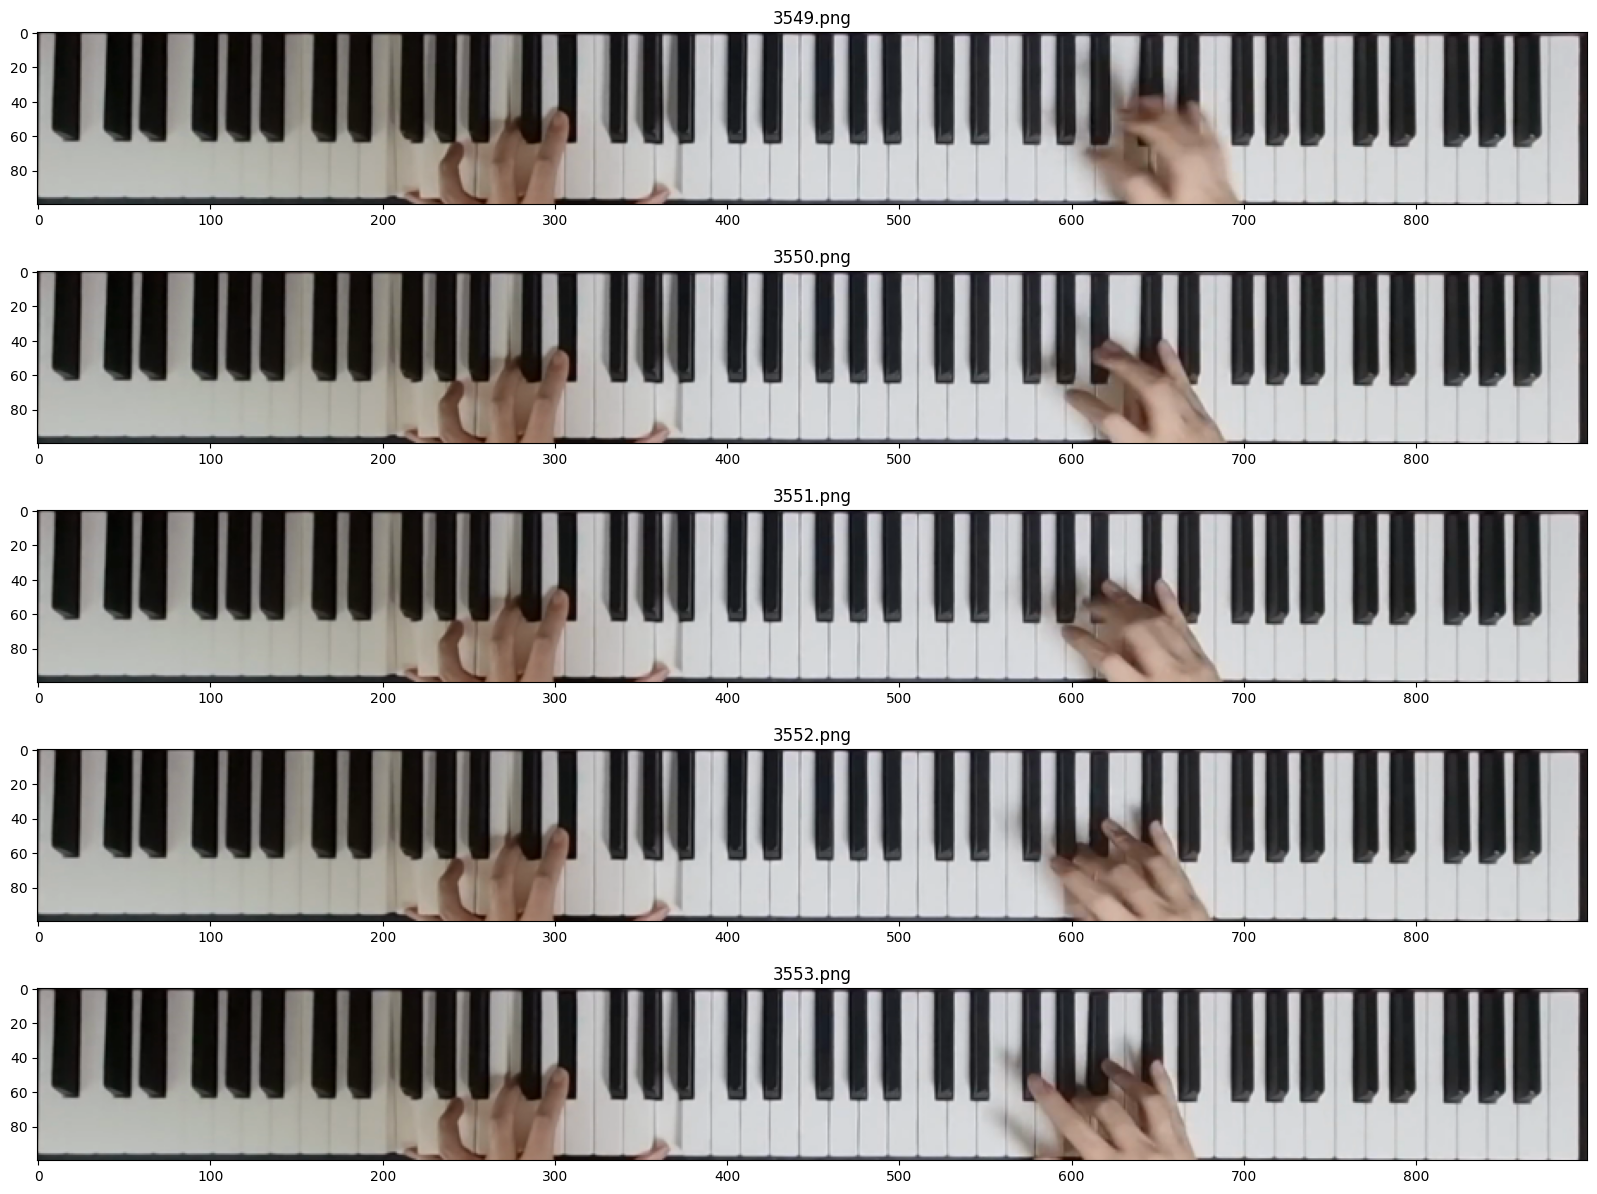

In [357]:
# randindex = random.randrange(1, test_label_last_idx)
randindex = 3551
print(intkey_to_str(np.where(test_label_np[randindex]>0)[0]))
show_5_images_test(randindex)

['G#5', 'F6', 'G6']


/tmp/ipykernel_17258/476807092.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(5, 1, 1)


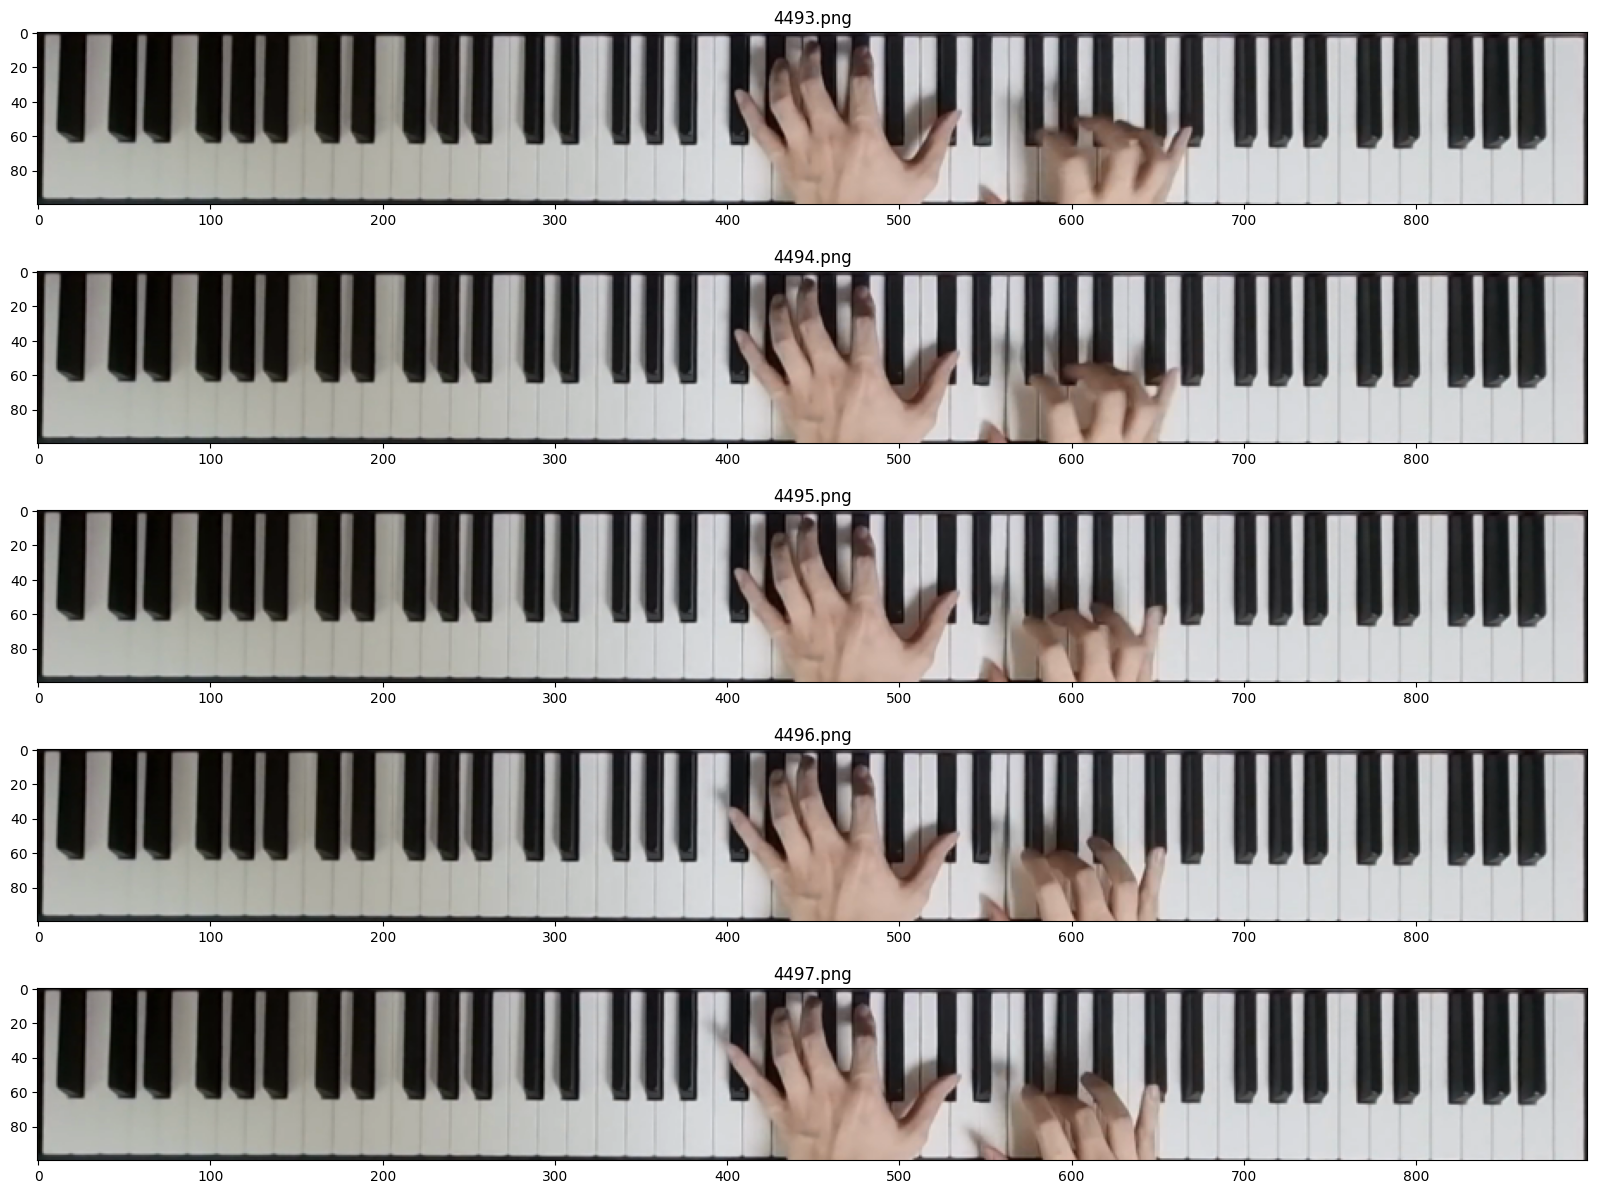

In [353]:
# randindex = random.randrange(1, test_label_last_idx)
randindex = 4495
print(intkey_to_str(np.where(test_label_np[randindex]>0)[0]))
show_5_images_test(randindex)

In [547]:
data = "./data/customdata/labels_align/testing/1105_lark.mp4.pkl"
np_check = np.load(data, allow_pickle=True)

In [544]:
np_check[2] = np.zeros(88) 
del np_check[0]

In [545]:
np_new = dict(sorted(np_check.items()))

In [546]:
with open(data, "wb") as f:
    pickle.dump(np_new, f)

In [548]:
np_check

{1: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),
 2: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),
 3: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.,